## Auditing Allocative Bias

[Source code is here.](https://github.com/jackgreenburg/jackgreenburg.github.io/blob/main/posts/auditing-allocative-bias/)

In this blog post I create a model that predicts employment status from a few features such as age, sex, and disability status, and I then analyze it for racial bias. Notably, race was not one of the features used, but its effects as a feature can be mimicked from combinations of other features.

### Preparing Dataset

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter

# I chose to stay using Alabama, since they didn't seem to have DC. Roll Tide
STATE = "AL"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

I picked these features:

- SCHL - level of schooling

- MAR - marital status

- AGEP - age

- MIL - military experience 

- DIS - disability status

- SEX

Also note, for RAC1P:

1. White alone

2. Black or African American alone

3. American Indian alone

4. Alaska Native alone

5. American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races

6. Asian alone

7. Native Hawaiian and Other Pacific Islander alone

8. Some Other Race alone

9. Two or More Races

But 4, 5, and 6 did not have enough examples, so I folded them into the Some Other Race category. The new indices are:

1. White alone

2. Black or African American alone

3. American Indian alone

4. Asian alone

5. Some Other Race alone

6. Two or More Races

In [5]:
feature_categories = ["SCHL", "MAR", "AGEP", "DIS", "SEX", "NATIVITY"]

EmploymentProblem = BasicProblem(
    features=feature_categories,
    target='ESR',
    target_transform=lambda x: x == 1,  # 1 means employed
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

# fold some races into "other" category
group[(group==4) | (group==5) | (group==7)] = 8
group[group==6] = 4
group[group==8] = 5
group[group==9] = 6

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

df = pd.DataFrame(X_train, columns = feature_categories)
df["group"] = group_train
df["label"] = y_train

#### Some notes about the data

1. There are 38221 individuals in the dataset.
2. Of those individuals, 15638 are employed
3, 4. Number and ratio employed by group:
     Race                     Employed      Ratio Employed
  1. White:                     12020              42.26% 
  2. Black:                      2976              36.88% 
  3. American Indian:              68              43.59% 
  4. Asian:                       226               50.0% 
  5. Other Race:                  157              35.76% 
  6. Two or More Races:           191              28.81% 
5. A plot showing percent of those who have a disability who are employed, by race:


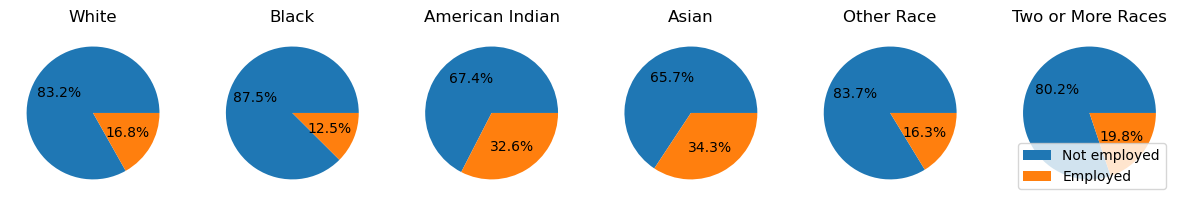

In [142]:
races = [
    "White",
    "Black",
    "American Indian",
    "Asian",
    "Other Race",
    "Two or More Races"
]

print(f"1. There are {df.shape[0]} individuals in the dataset.")
print(f"2. Of those individuals, {df.label.sum()} are employed")
print(f"3, 4. Number and ratio employed by group:")

employee_races = df[df["label"] == True]["group"]
employed_per_group = employee_races.value_counts(sort=False)
ratio_employed_per_group = employed_per_group/df["group"].value_counts(sort=False)

print("     Race".ljust(28) + "Employed".rjust(10) + "Ratio Employed".rjust(20))
for index, race in enumerate(races):
    line = f"  {index+1}. {race}:".ljust(28)
    line += f"{employed_per_group[index+1]} ".rjust(10)
    line += f"{round(ratio_employed_per_group[index+1] * 100, 2)}% ".rjust(20)
    print(line)

# plot disability race intersection
group_dict = {i+1: status for i, status in enumerate(races)}
working_by_race = df.query("DIS==1")[["label", "group"]].value_counts(sort=False)
fig, axarr = plt.subplots(1, 6, figsize=(15, 5))
for i, (index, race) in enumerate(group_dict.items()):
    axarr[i].pie((working_by_race[False][index], working_by_race[True][index]), autopct='%1.1f%%')
    axarr[i].set_title(race)
plt.legend(labels=["Not employed", "Employed"], loc="lower right")
print(f"5. A plot showing percent of those who have a disability who are employed, by race:")

### Creating a Predictor

I performed a grid search with `max_depth=[5, 10]` and `max_features=[10, 20, 50]` and it found `max_depth=5` and `max_features=10` to be optimal.

In [7]:
# parameters = {"gradientboostingclassifier__max_depth": (5, 10),
#               "gradientboostingclassifier__max_features": (10, 20, 50)}
# pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier())
# clf = GridSearchCV(pipeline, 
#                    parameters, 
#                    scoring="accuracy")
# clf.fit(X_train, y_train)

pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(max_depth=5, max_features=10))
clf = pipeline.fit(X_train, y_train)

y_pred = clf.predict(X_test)

pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5, max_features=10))])>

### Auditing the Model

#### Overall and By Group Measures


In [8]:
def compute_measures(*, y_test, y_pred, print_bool=False):
    (TN, FP), (FN, TP) = confusion_matrix(y_test, y_pred)
    data = {
        "Accuracy": (y_pred == y_test).mean(),
        "PPV": TP / (TP+FP),
        "FPR": FP / (FP+TN),
        "FNR": FN / (TP+FN)       
    }

    data["Predicted Employed"] = (TP + FP) / (TP + FP + TN + FN)

    if print_bool: 
        for key, value in data.items(): print(f"{key}: {round(value * 100, 2)}%")
    return data

print("All data:")
compute_measures(y_test=y_test, y_pred=y_pred, print_bool=True)

audit_dict = {}
for index, race in group_dict.items():
    # print(f"\n{race} subgroup:")
    audit_dict[race] = compute_measures(y_test=y_test[group_test==index], y_pred=y_pred[group_test==index])
pd.DataFrame(audit_dict).T

All data:
Accuracy: 81.07%
PPV: 76.35%
FPR: 17.0%
FNR: 21.69%
Predicted Employed: 42.26%


,Accuracy,PPV,FPR,FNR,Predicted Employed
White,0.809845,0.776081,0.169746,0.217306,0.432771
Black,0.814670,0.722981,0.170620,0.211382,0.393643
American Indian,0.769231,0.700000,0.187500,0.300000,0.384615
Asian,0.711538,0.690909,0.320755,0.254902,0.528846
Other Race,0.868687,0.864865,0.084746,0.200000,0.373737
Two or More Races,0.831395,0.666667,0.144000,0.234043,0.313953


In [156]:
print("Ground truth percentages employed for reference:")
true_employment_percentages = df.query('label==True')['group'].value_counts(sort=False) / df['group'].value_counts(sort=True)
for (index, race), percentage in zip(group_dict.items(), true_employment_percentages):
    print(f"{index}. {race}: {round(percentage*100, 2)}%")

Ground truth percentages employed for reference:
1. White: 42.26%
2. Black: 36.88%
3. American Indian: 43.59%
4. Asian: 50.0%
5. Other Race: 35.76%
6. Two or More Races: 28.81%


##### Bias Measures
- Is your model approximately calibrated?

  My model should be calibrated. The score threshold for a positive prediction should be the same across all samples in the dataset.

- Does your model satisfy approximate error rate balance?

  My model does not fully satisfy error rate balance. The two largest groups (white and black) have similar FPR (~17%) and FNR (~22%), but many of the classes with lower prevalence have quite different rates. 

- Does your model satisfy statistical parity?
  
  My model does not satisfy statistical parity. Predicted employment percentages vary over a range of about 20 percentage points.

#### Intersectional Bias

In [45]:
bias_df = pd.DataFrame(X_test, columns = feature_categories)
bias_df["group"] = group_test
bias_df["label"] = y_test

intersectional_audit_dict = {}
for index, race in group_dict.items():
    for subgroup in [1, 2]:
        # print(f"\n{race} subgroup:")
        include_bool_arr = (group_test==index) | (bias_df["DIS"] == subgroup)
        intersectional_audit_dict[f"With{['', 'out'][subgroup-1]} Disability, {race}"] = compute_measures(
            y_test=y_test[include_bool_arr], 
            y_pred=y_pred[include_bool_arr]
        )
pd.DataFrame(intersectional_audit_dict).T


,Accuracy,PPV,FPR,FNR,Predicted Employed
"With Disability, White",0.812352,0.774298,0.156832,0.231657,0.408683
"Without Disability, White",0.808649,0.764808,0.181000,0.205327,0.442121
"With Disability, Black",0.825578,0.716609,0.099673,0.363261,0.251975
"Without Disability, Black",0.805474,0.765445,0.208575,0.177550,0.486559
"With Disability, American Indian",0.844875,0.623377,0.019256,0.839465,0.042659
"Without Disability, American Indian",0.802623,0.766054,0.224994,0.166118,0.510608
"With Disability, Asian",0.838470,0.636364,0.028479,0.771513,0.064293
"Without Disability, Asian",0.802648,0.766365,0.224861,0.166256,0.510671
"With Disability, Other Race",0.847304,0.699029,0.020052,0.779817,0.054992
"Without Disability, Other Race",0.802621,0.766113,0.224831,0.166301,0.510409


The false negative rates here are really interesting. It seems that the model does not significantly alter its prediction based off  disability for white people, but for every other racial category the changes are quite large. These numbers almost make sense when you look at the above pie plots: Asian's and American Indian's with disabilities are twice as likely to be working. This would partially explain why their false negative rates are high, but it wouldn't explain the other races with very high FNRs.

##### Feature Importances (I was curious) 

In [10]:
for feat, importance in zip(feature_categories, clf[1].feature_importances_):
    print(f"{feat}:, {round(importance*100, 2)}%")

SCHL:, 36.14%
MAR:, 2.65%
AGEP:, 46.12%
DIS:, 11.35%
SEX:, 3.1%
NATIVITY:, 0.64%


### Concluding Discussion

A model trained to predict unemployment could be used for a variety of purposes. Here are two examples where it could be used: 

1. It could be used to direct job ads to people that are unemployed, hoping to find people that are looking for work.
2. It could be used to direct job ads to only people that are employed, viewing the unemployed as undesirable. 

In this sense, depending on its application, it could both help and hurt unemployed people. If we take American Indians as an example, since my model only had a very low FPR for them, they would be less likely to be excluded from job ads targeted to unemployed people, and more likely to be excluded from ads targeted to employed people.

The actual real world applications for my model specifically are slim. For starters, it is a very mediocre classifier, but, also, a model trained to predict employment status from the identifiers that I used could only be used by somebody with access to a bizarre dataset. The features I used are generally not easier to come by than employment status is to gain directly. Furthermore, the features that are harder to acquire are the more important ones. Perhaps Instagram or Facebook could analyze your account to come up with age, sex, and relationship status, but level of schooling and disability seem much harder, and for little payoff. To put it plainly, anybody that really needs employment status usually has the ability to ask directly, and if they can't ask then they're probably not going to have the data necessary to predict it.

I think my model does display some problematic bias. The most concerning issue to me is the error rate balance. More specifically, I am concerned by how high the FPR is for American Indians and how high the FNR is for Asians. Most of the other values are relatively in line with each other, but these two stand out. If this model were to be implemented it, then American Indians and Asians would not be properly represented.

Beyond concerns of bias, I think my model is incredibly innocuous. A model that predicted employment status through gait or clothing would be much more dangerous since it could be employed so much wider. The issue of acquiring the data necessary makes my model highly impractical to actually use by someone with malicious intentions.